In [1]:
# Import classes for generating sequences
import torch
from torch import nn
import numpy as np
from GenerateVT import GenerateVT
from MassFricParams import MassFricParams
from TimeSequenceGen import TimeSequenceGen
from TimeSequenceGen_NN import TimeSequenceGen_NN
from matplotlib import pyplot as plt
from matplotlib import rc
from FrictionNNModels import plotGenVXFric, relativeL2
import time
# For plotting
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


In [50]:
# Generating a VT sequence for the spring slider
VTkwgs = {
        'logVDist' : True, 
        'Vrange' : [-2., 1.], 
        'Trange' : [0., 2.0], 
        'NofTpts' : 10, 
        'flag' : 'simple', 
        'nOfTerms' : 3, 
}
myVT = GenerateVT(VTkwgs)

In [51]:
myVT.VT

tensor([[1.0000, 1.0000, 1.3616, 1.3616, 1.3616, 1.3616, 0.5335, 0.5335, 0.5335,
         0.5335],
        [0.0000, 0.2222, 0.4444, 0.6667, 0.8889, 1.1111, 1.3333, 1.5556, 1.7778,
         2.0000]])

In [5]:
# Generate a time sequence
# Spring slider parameters
kmg = [5000., 1., 9.8]

# Rate and state parameters
RSParams = [0.011, 0.016, 1. / 1.e-2, 0.58]

# Solver specific parameters
rtol, atol = 1.e-8, 1.e-10 
regularizedFlag = False

# Solver-specific settings
# solver = 'dopri5'
solver = 'implicit_adams'
max_iters = 20
# step_sizes = [pow(2., i) for i in np.linspace(-15, -11, num = 2)]
step_sizes = []

# Store the results
Frics = []
Vs = []
xs = []
legends = ["$\Delta t = {0}$ s".format(step_size) for step_size in step_sizes]

## Loop thru all step_sizes
for step_size in step_sizes:
    solver_options = {
        'max_iters' : max_iters, 
        'step_size' : step_size, 
    }

    # Initial condition
    y0 = torch.tensor([0., 1., 1. / RSParams[2]])
    myMFParams = MassFricParams(kmg, myVT.VT, RSParams, y0, lawFlag = "aging", regularizedFlag = regularizedFlag)

    # Start timer
    st = time.time()

    # Set for my sequence
    myTimeSeq = TimeSequenceGen(myVT.Trange[1], 
                                10, 
                                myMFParams, 
                                rtol, 
                                atol, 
                                regularizedFlag, 
                                solver, 
                                solver_options)
    
    Vs.append(myTimeSeq.default_y[1, :])
    xs.append(myTimeSeq.default_y[0, :])
    Frics.append(myTimeSeq.Fric)
    print("-"* 25, " Dt = {0}, {1} s.".format(step_size, time.time() - st), "-"* 25)


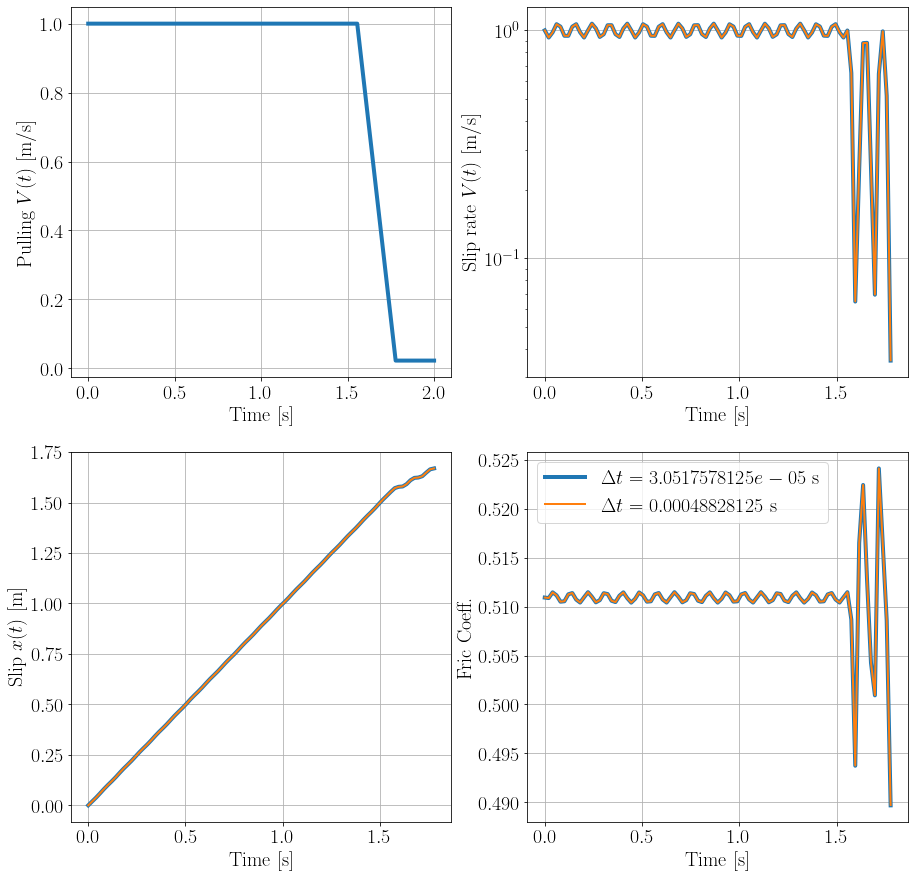

In [19]:
f, axs = plotGenVXFric(myVT.VT[0, :], myVT.VT[1, :], myTimeSeq.t, Vs, xs, Frics, legends)

In [8]:
# Try loading the model
# Load the learnt model from storage
from FrictionNNModels import PotentialsFricCorrection, Loss, train1Epoch, PP, ReLUSquare, FricCorrection, load_model

modelPrefix = "Trial0216_combined_800"
# modelPrefix = "Trial0216_smallDRS_smallA_400"
dim_xi = 1

# Get correct device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

myModel = load_model(modelPrefix, device, dim_xi, True, NN_Flag=1)

In [21]:
# Solver-specific settings
# solver = 'dopri5'
solver = 'implicit_adams'
max_iters = 20

step_sizes = [pow(2., i) for i in np.linspace(-12, -11, num = 2)]

# Store the results
Fric_NNs = []
V_NNs = []
x_NNs = []
legend_NNs = ["$\Delta t = {0}$ s".format(step_size) for step_size in step_sizes]

for step_size in step_sizes:
    solver_options = {
        'max_iters' : max_iters, 
        'step_size' : step_size, 
    }

    # Start the timer
    st = time.time()
    
    # Compute slip rate for the same input sequence using NN model
    myTimeSeqNN = TimeSequenceGen_NN(myVT.Trange[1], 
                                    10, 
                                    myMFParams, 
                                    myModel, 
                                    rtol, 
                                    atol, 
                                    solver, 
                                    solver_options,  
                                    fOffSet = 0.5109, 
                                    scaling_factor = 50.)

    V_NNs.append(myTimeSeqNN.default_y[1, :])
    x_NNs.append(myTimeSeqNN.default_y[0, :])
    Fric_NNs.append(myTimeSeqNN.Fric)
    print("-"* 25, " Dt = {0}, {1} s.".format(step_size, time.time() - st), "-"* 25)

Error: Canceled future for execute_request message before replies were done

# Test on more sequences


In [9]:
import random

# Store the results
NofSeqs = 200
y_RSs = []
y_NNs = []
Fric_RSs = []
Fric_NNs = []
myVTs = []
ks = []
ts = []

# Set up solver info
solver = 'rk4'
solver_options = dict()

VTkwgs = {
        'logVDist' : True, 
        'Vrange' : [-2., 1.], 
        'Trange' : [0., 0.5], 
        'NofTpts' : 10, 
        'flag' : 'simple', 
        'nOfTerms' : 3, 
}

y0 = torch.tensor([0., 1., 1. / RSParams[2]])

# Start generating sequences
id = 0
while id < NofSeqs:
    k = 10. ** (random.random() * 3. + 1.)
    kmg = [k, 1., 9.8]
    myVT = GenerateVT(VTkwgs)
    myMFParams = MassFricParams(kmg, myVT.VT, RSParams, y0, lawFlag = "aging", regularizedFlag = True)

    # Set for my sequence
    myTimeSeq = TimeSequenceGen(myVT.Trange[1], 
                                10, 
                                myMFParams, 
                                rtol, 
                                atol, 
                                regularizedFlag, 
                                solver, 
                                solver_options)
    
    # Check if there is nan in myTimeSeq
    if torch.any(torch.isnan(myTimeSeq.default_y)):
        continue
    # Compute slip rate for the same input sequence using NN model
    myTimeSeqNN = TimeSequenceGen_NN(myVT.Trange[1], 
                                        10, 
                                        myMFParams, 
                                        myModel, 
                                        rtol, 
                                        atol, 
                                        solver,
                                        solver_options,
                                        fOffSet = 0.5109, 
                                        scaling_factor = 50.)
    
    # Check if there is nan in myTimeSeqNN
    if torch.any(torch.isnan(myTimeSeqNN.default_y)):
        continue
    
    # Store the results
    y_RSs.append(myTimeSeq.default_y)
    y_NNs.append(myTimeSeqNN.default_y)
    Fric_RSs.append(myTimeSeq.Fric)
    Fric_NNs.append(myTimeSeqNN.Fric)
    myVTs.append(myVT)
    ks.append(k)
    ts.append(myTimeSeq.t)

    # Update id
    id += 1
    if id % 10 == 0:
        print("Finished sampling {0} sequences.".format(id), flush=True)

Finished sampling 10 sequences.
Finished sampling 20 sequences.
Finished sampling 30 sequences.
Finished sampling 40 sequences.
Finished sampling 50 sequences.
Finished sampling 60 sequences.
Finished sampling 70 sequences.
Finished sampling 80 sequences.
Finished sampling 90 sequences.
Finished sampling 100 sequences.
Finished sampling 110 sequences.
Finished sampling 120 sequences.
Finished sampling 130 sequences.
Finished sampling 140 sequences.
Finished sampling 150 sequences.
Finished sampling 160 sequences.
Finished sampling 170 sequences.
Finished sampling 180 sequences.
Finished sampling 190 sequences.
Finished sampling 200 sequences.


In [10]:
# save results
res = {
    'y_RSs' : y_RSs, 
    'y_NNs' : y_NNs, 
    'Fric_RSs' : Fric_RSs, 
    'Fric_NNs' : Fric_NNs, 
    'myVTs' : myVTs, 
    'ks' : ks, 
    'RSParams' : RSParams,
    'rtol' : rtol, 
    'atol' : atol,
    'ts' : ts, 
    'regularizedFlag' : regularizedFlag, 
    'solver' : solver, 
}

torch.save(res, './data/testSpringSlider0515_200.pth')

In [12]:
# Report relative L-2 error on friction coefficient, slip rate on the slider
res = torch.load('./data/testSpringSlider0515_200.pth')

# Report relative L2 error in x, V, and friction
err_x = []
err_V = []
err_Fric = []
fOffSet, scaling_factor = 0.5109, 50.

for i in range(len(res['ks'])):
    this_NN_Fric = (res['Fric_NNs'][i] - fOffSet) * scaling_factor + fOffSet
    this_RS_Fric = (res['Fric_RSs'][i] - fOffSet) * scaling_factor + fOffSet

    err_x.append(relativeL2(res['y_NNs'][i][0, :], res['y_RSs'][i][0, :], res['ts'][i]))
    err_V.append(relativeL2(res['y_NNs'][i][1, :], res['y_RSs'][i][1, :], res['ts'][i]))
    err_Fric.append(relativeL2(this_NN_Fric, this_RS_Fric, res['ts'][i]))

# Err into tensors
err_x = torch.stack(err_x)
err_V = torch.stack(err_V)
err_Fric = torch.stack(err_Fric)

# Report the mean and standard deviation in L2 errors
std, mean = torch.std_mean(err_x)
print("Mean, std of L2 error in x: {0}, {1}".format(mean, std))
std, mean = torch.std_mean(err_V)
print("Mean, std of L2 error in V: {0}, {1}".format(mean, std))
std, mean = torch.std_mean(err_Fric)
print("Mean, std of L2 error in Friction: {0}, {1}".format(mean, std))


Mean, std of L2 error in x: 0.0002893121272791177, 0.0007280813297256827
Mean, std of L2 error in V: 0.0009066747734323144, 0.0017560651758685708
Mean, std of L2 error in Friction: 0.07044655829668045, 0.06889547407627106


# Plot the error distribution of x, V and Friction

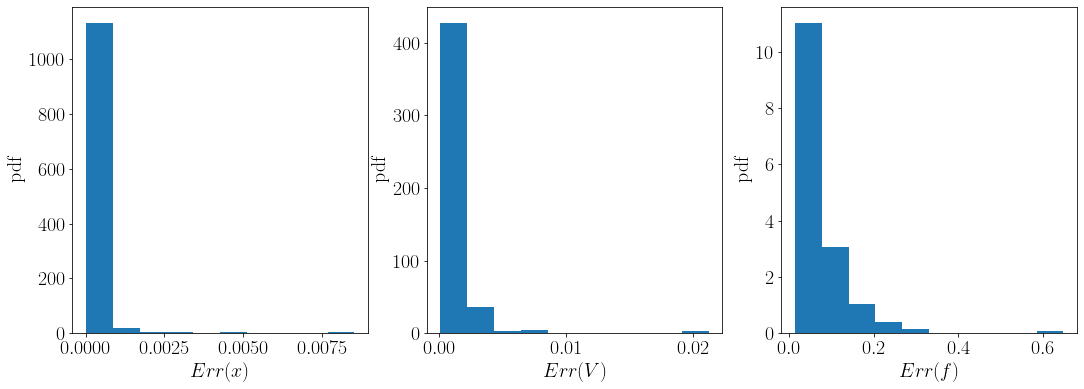

In [13]:
# Set up histograms
fsize = 20
fig, axs = plt.subplots(ncols = 3, figsize = (18, 6))
nBins = 10
hist_data = [err_x, err_V, err_Fric]
hist_xlabels = ["$Err(x)$", "$Err(V)$", "$Err(f)$"]

# Loop through dataPrefixs
for idx, (h_data, h_xlabel) in enumerate(zip(hist_data, hist_xlabels)):
    axs[idx].tick_params(axis='both', which='major', labelsize=fsize)
    axs[idx].hist(h_data.detach().numpy(), bins=nBins, density=True)
    axs[idx].set_xlabel(h_xlabel, fontsize=fsize)
    axs[idx].set_ylabel("pdf", fontsize=fsize)

# Plot an example sequence

Text(0.5, 0.98, 'Sequence 120')

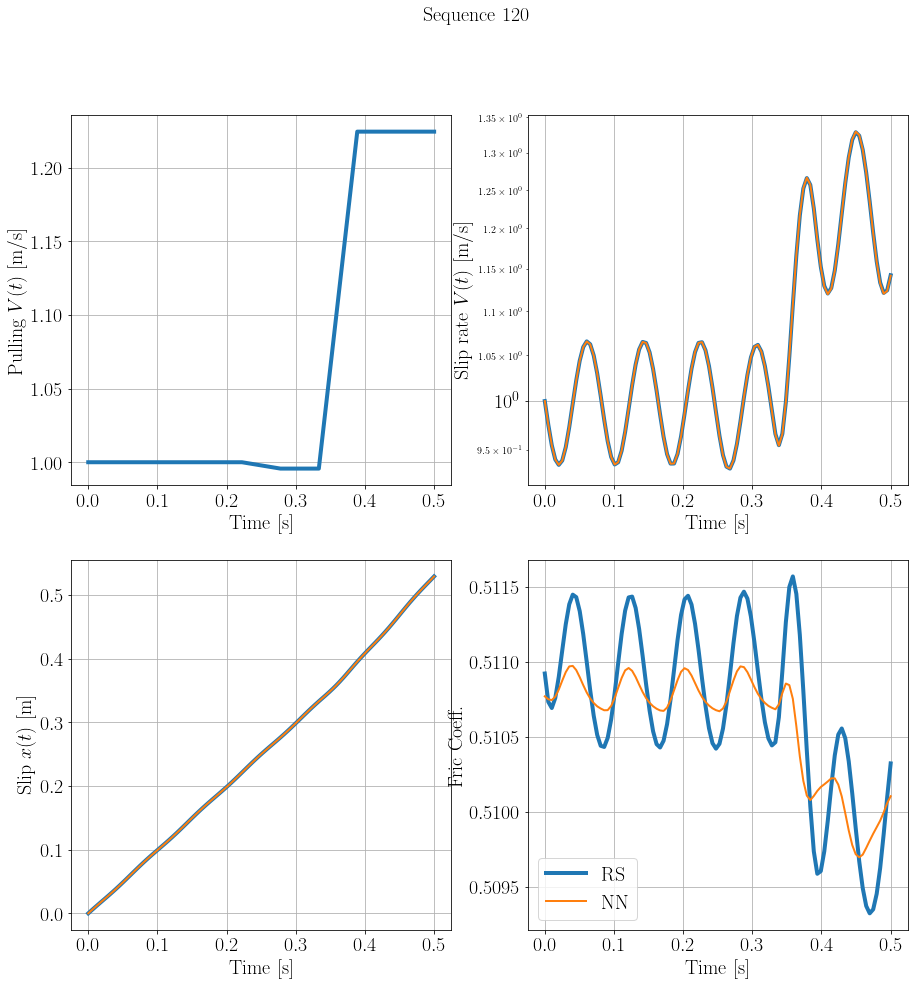

In [19]:
# Plot a sequence
# Plot the sequences from NN and rate-and-state friction on the same plot
import random
NofSeqs = 200

# Plot a sequence
idx = random.randint(0, NofSeqs)
VV, tt = res['myVTs'][idx].VT[0, :], res['myVTs'][idx].VT[1, :]
t = res['ts'][idx]
Vs = [res['y_RSs'][idx][1, :], res['y_NNs'][idx][1, :]]
xs = [res['y_RSs'][idx][0, :], res['y_NNs'][idx][0, :]]
Frics = [res['Fric_RSs'][idx], res['Fric_NNs'][idx]]
f, axs = plotGenVXFric(VV, tt, t, Vs, xs, Frics, legends=["RS", "NN"])
f.suptitle("Sequence {0}".format(idx), fontsize=20)

# Load sequences with "rk" and "implicit_adams"

In [19]:
# Loop through all sequences, compute relative error
PATH = "./data/RSvsNNSpringSliderAcc0514/"
fore_names = ["res_NN_seq", "res_NN_ex_seq", "res_RS_im_seq", "res_RS_seq"]
legends = ["NN, implicit", "NN, explicit", "RS, implicit", "RS, explicit"]
NofSeqs = 63

# Store all err, declare whether or not using logV in the L2 error
logVFlag = False
rel_err_Vs = [[] for i in range(len(fore_names))]
rel_err_xs = [[] for i in range(len(fore_names))]


for i in range(NofSeqs):
    for idx, fore_name in enumerate(fore_names):
        res = torch.load(PATH + fore_name + "_{0}.pth".format(i))
        this_err_logV = []
        this_err_x = []
        for j in range(1, len(res['Vs'])):
            if logVFlag == True:
                this_err_logV.append(relativeL2(torch.log10(torch.abs(res['Vs'][j])), 
                                                torch.log10(torch.abs(res['Vs'][0])), 
                                                res['t']))
            else:
                this_err_logV.append(relativeL2(res['Vs'][j], 
                                                res['Vs'][0], 
                                                res['t']))

            this_err_x.append(relativeL2(res['xs'][j], res['xs'][0], res['t']))
        rel_err_Vs[idx].append(this_err_logV)
        rel_err_xs[idx].append(this_err_x)

In [48]:
# Calculate average error
import pandas as pd
import numpy as np
my_df_Vs = []
my_df_xs = []

mean_Vs = []
std_Vs = []
nan_Vs = []

mean_xs = []
std_xs = []
nan_xs = []

# Create a df for each model-ode solver combination
for idx, fore_name in enumerate(fore_names):
    data = torch.load(PATH + fore_name + "_{0}.pth".format(i))
    col_names = data['step_sizes'][1:]
    this_df_V = pd.DataFrame(np.array(rel_err_Vs[idx]), 
                             columns = col_names)
    this_df_V[this_df_V > 0.2] = np.nan
    
    mean_Vs.append(list(this_df_V.mean(axis=0, skipna=True).values))
    std_Vs.append(list(this_df_V.std(axis=0, skipna=True).values))
    nan_Vs.append(list(this_df_V.isna().sum(axis=0).values / len(this_df_V)))

    this_df_x = pd.DataFrame(np.array(rel_err_xs[idx]), 
                             columns = col_names)
    this_df_x[this_df_x > 0.2] = np.nan

    mean_xs.append(list(this_df_x.mean(axis=0, skipna=True).values))
    std_xs.append(list(this_df_x.std(axis=0, skipna=True).values))
    nan_xs.append(list(this_df_x.isna().sum(axis=0).values / len(this_df_x)))

    my_df_Vs.append(this_df_V)
    my_df_xs.append(this_df_x)

V_mean_df = pd.DataFrame(np.array(mean_Vs), columns = col_names, index=legends)
V_std_df = pd.DataFrame(np.array(std_Vs), columns = col_names, index=legends)
V_nan_df = pd.DataFrame(np.array(nan_Vs), columns = col_names, index=legends)
x_mean_df = pd.DataFrame(np.array(mean_xs), columns = col_names, index=legends)
x_std_df = pd.DataFrame(np.array(std_xs), columns = col_names, index=legends)
x_nan_df = pd.DataFrame(np.array(nan_xs), columns = col_names, index=legends)

In [49]:
V_mean_df

,0.000488,0.000977,0.001953,0.003906,0.007812,0.015625,0.031250
"NN, implicit",0.000008,0.000046,0.001200,0.003352,0.010628,0.015043,0.021268
"NN, explicit",0.000006,0.000025,0.000098,0.000393,0.001690,0.008252,0.032673
"RS, implicit",0.000005,0.000020,0.000019,NaN,NaN,0.004910,0.005468
"RS, explicit",0.000006,0.000024,0.000097,0.000392,0.001350,0.006268,0.016085


In [50]:
V_std_df

,0.000488,0.000977,0.001953,0.003906,0.007812,0.015625,0.031250
"NN, implicit",0.000010,0.000104,0.005345,0.008237,0.017131,0.031919,0.030928
"NN, explicit",0.000008,0.000035,0.000136,0.000547,0.002506,0.012413,0.043924
"RS, implicit",0.000006,0.000045,0.000002,NaN,NaN,NaN,0.000573
"RS, explicit",0.000008,0.000035,0.000136,0.000546,0.001613,0.007712,0.041167


In [51]:
V_nan_df

,0.000488,0.000977,0.001953,0.003906,0.007812,0.015625,0.031250
"NN, implicit",0.000000,0.000000,0.222222,0.365079,0.412698,0.396825,0.269841
"NN, explicit",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015873
"RS, implicit",0.380952,0.730159,0.904762,1.000000,1.000000,0.984127,0.968254
"RS, explicit",0.000000,0.000000,0.000000,0.000000,0.142857,0.396825,0.809524


In [32]:
my_df_Vs[0].std(axis=0, skipna=True).values

array([9.5329324e-06, 1.0395163e-04, 5.3451057e-03, 8.2365917e-03,
       1.7131221e-02, 1.0594217e-02, 2.1822339e-02], dtype=float32)

(<Figure size 1080x1080 with 4 Axes>,
 array([[<AxesSubplot:xlabel='Time [s]', ylabel='Pulling $V(t)\\  \\mathrm{[m/s]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Slip rate $V(t)\\ \\mathrm{[m/s]}$'>],
        [<AxesSubplot:xlabel='Time [s]', ylabel='Slip $x(t)\\  \\mathrm{[m]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Fric Coeff.'>]],
       dtype=object))

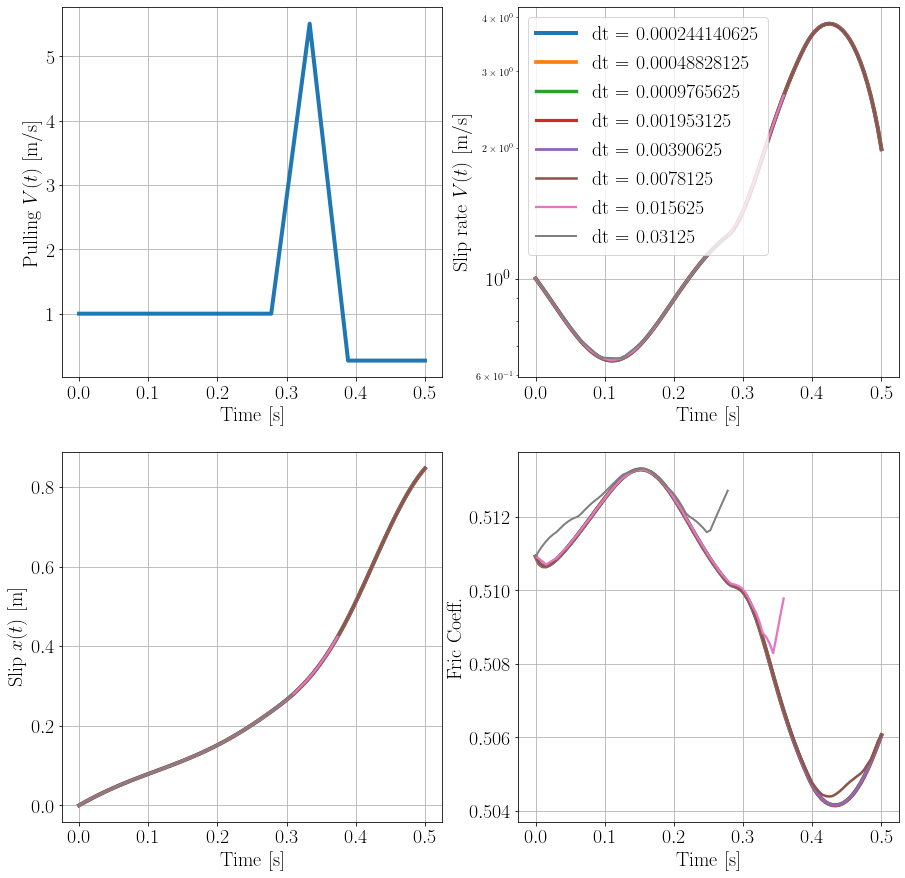

In [8]:
# Visualize simulation sequences
# Visualize results of rk solver on different step sizes
idx = 6
res = torch.load("./data/RSvsNNSpringSliderAcc0514/res_RS_seq_{0}.pth".format(idx))
plotGenVXFric(res['VT'].VT[0, :], res['VT'].VT[1, :], res['t'], 
              res['Vs'], 
              res['xs'], 
              res['Frics'], 
              ["dt = {0}".format(leg) for leg in res['step_sizes']])

(<Figure size 1080x1080 with 4 Axes>,
 array([[<AxesSubplot:xlabel='Time [s]', ylabel='Pulling $V(t)\\  \\mathrm{[m/s]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Slip rate $V(t)\\ \\mathrm{[m/s]}$'>],
        [<AxesSubplot:xlabel='Time [s]', ylabel='Slip $x(t)\\  \\mathrm{[m]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Fric Coeff.'>]],
       dtype=object))

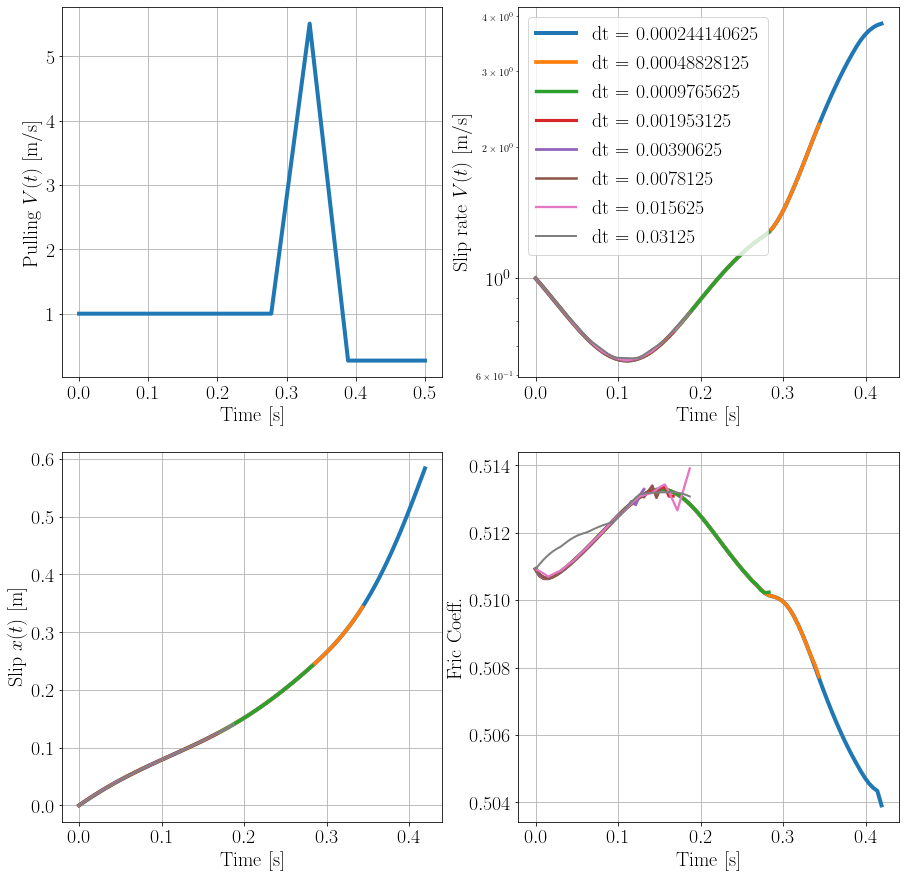

In [9]:
res = torch.load("./data/RSvsNNSpringSliderAcc0514/res_RS_im_seq_{0}.pth".format(idx))
plotGenVXFric(res['VT'].VT[0, :], res['VT'].VT[1, :], res['t'], 
              res['Vs'], 
              res['xs'], 
              res['Frics'], 
              ["dt = {0}".format(leg) for leg in res['step_sizes']])

(<Figure size 1080x1080 with 4 Axes>,
 array([[<AxesSubplot:xlabel='Time [s]', ylabel='Pulling $V(t)\\  \\mathrm{[m/s]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Slip rate $V(t)\\ \\mathrm{[m/s]}$'>],
        [<AxesSubplot:xlabel='Time [s]', ylabel='Slip $x(t)\\  \\mathrm{[m]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Fric Coeff.'>]],
       dtype=object))

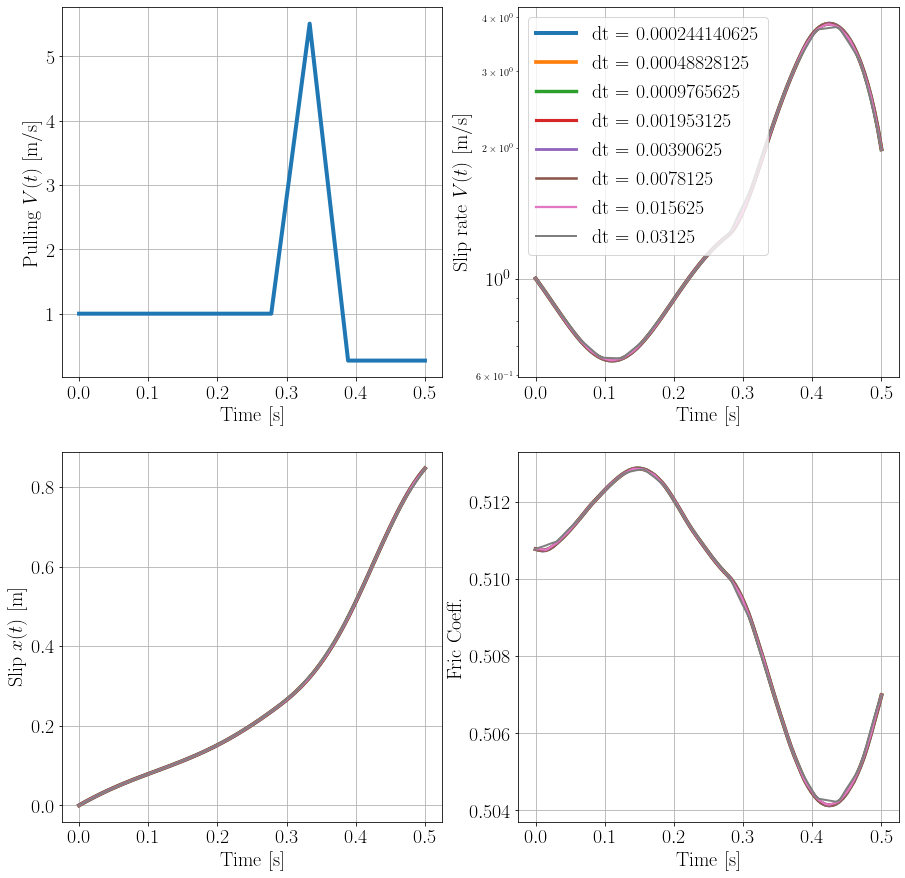

In [10]:
res = torch.load("./data/RSvsNNSpringSliderAcc0514/res_NN_ex_seq_{0}.pth".format(idx))
plotGenVXFric(res['VT'].VT[0, :], res['VT'].VT[1, :], res['t'], 
              res['Vs'], 
              res['xs'], 
              res['Frics'], 
              ["dt = {0}".format(leg) for leg in res['step_sizes']])

(<Figure size 1080x1080 with 4 Axes>,
 array([[<AxesSubplot:xlabel='Time [s]', ylabel='Pulling $V(t)\\  \\mathrm{[m/s]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Slip rate $V(t)\\ \\mathrm{[m/s]}$'>],
        [<AxesSubplot:xlabel='Time [s]', ylabel='Slip $x(t)\\  \\mathrm{[m]}$'>,
         <AxesSubplot:xlabel='Time [s]', ylabel='Fric Coeff.'>]],
       dtype=object))

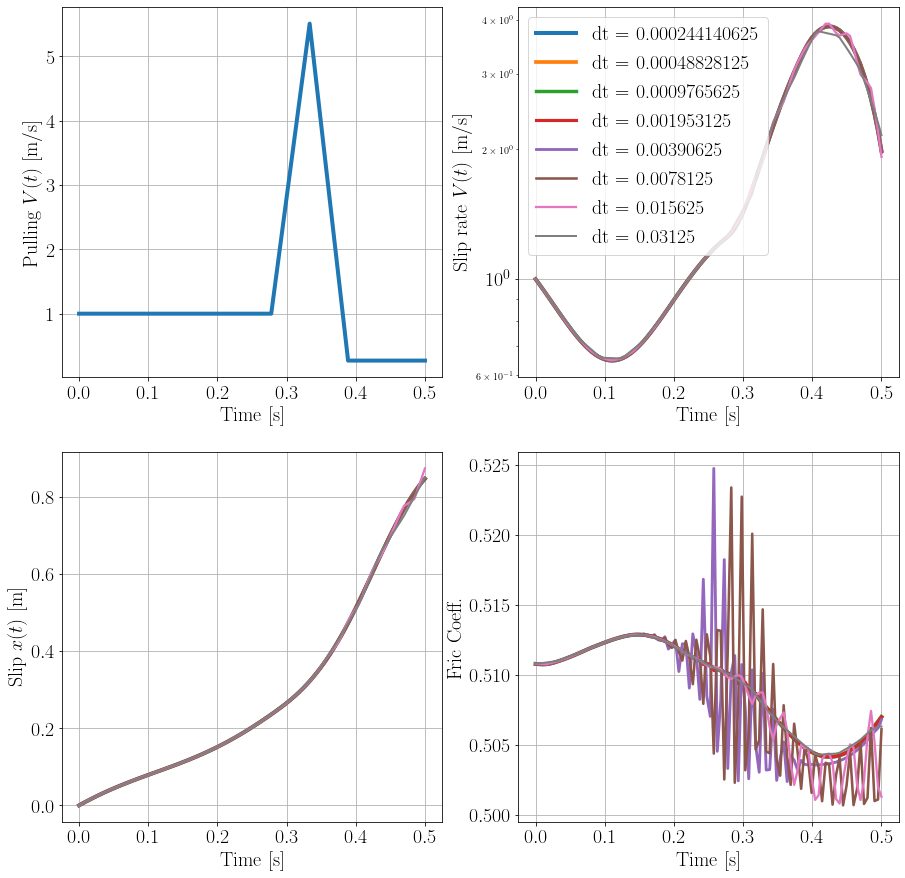

In [11]:
res = torch.load("./data/RSvsNNSpringSliderAcc0514/res_NN_seq_{0}.pth".format(idx))
plotGenVXFric(res['VT'].VT[0, :], res['VT'].VT[1, :], res['t'], 
              res['Vs'], 
              res['xs'], 
              res['Frics'], 
              ["dt = {0}".format(leg) for leg in res['step_sizes']])

In [ ]:
import pandas as pd
